# One-layer MOSAIKS

## Load utils

In [1]:
import os
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

/home/mila/s/sara.ebrahim-elkafrawy/.conda/envs/ffcv2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define the model: two-layer CNN

In [2]:
# load the 2-layer mosaiks model
# mosaiks+kmeans: 
# two_layer_mosaiks_kmeans_7_no_whiten_zcaBias_0.001_bias_True_filters_100
# two_layer_mosaiks_kmeans_7_whiten_allGeo_bs32_25eachimage_zcaBias_0.001_bias_True_filters_100
# original mosaiks:
# two_layer_mosaiks_original_7_no_whiten_zcaBias_0.001_bias_True_filters_100
# two_layer_mosaiks_original_7_whiten_zcaBias_0.001_bias_True_filters_100

main_dir = "/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/ckpts/mosaiks"
model_name = "two_layer_mosaiks_original_7_whiten_zcaBias_0.001_bias_True_filters_100.pt" 
num_filters_lyrs = [100, 64] #[512, 128] 
num_final_feats = 5184  #10368 (for 512 features)
conv_bias = True
num_species = 17037
# params to save the one-layer model
model_type = "one_layer_mosaiks_kmeans"
mode = "whiten"
kernel_size = 7
zca_bias = 0.001

In [3]:
# first trial: num_filters = [100, 64] with convolution bias and pool size of 256
# model = nn.Sequential(
#       nn.Conv2d(in_channels=3, out_channels=num_filters[0], kernel_size=kernel_size, padding='same', bias=True),
#       nn.LeakyReLU(),
#       nn.MaxPool2d(2, stride=2),

#       nn.Conv2d(in_channels=num_filters[0], out_channels=num_filters[1], kernel_size=kernel_size, padding='same', bias=True),
#       nn.LeakyReLU(),
#       nn.MaxPool2d(2, stride=2),
    
#       nn.AdaptiveAvgPool2d(9),
    
#       nn.Flatten(),
#       nn.Dropout(0.5),
#       nn.Linear(5184, 512), #50176
#       nn.ReLU(),
#       nn.Linear(512, num_species)
#       ) 

# second trial: num_filters = [512, 128] without conv bias and pool size of 2 
model = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=num_filters_lyrs[0], kernel_size=kernel_size, padding='same', bias=conv_bias),
      nn.LeakyReLU(),
      nn.MaxPool2d(2, stride=2),

      nn.Conv2d(in_channels=num_filters_lyrs[0], out_channels=num_filters_lyrs[1], kernel_size=kernel_size, padding='same', bias=conv_bias),
      nn.LeakyReLU(),
      nn.MaxPool2d(2, stride=2),
    
      nn.AdaptiveAvgPool2d(9),
    
      nn.Flatten(),
      nn.Dropout(0.5),
      nn.Linear(num_final_feats, 512),
      nn.ReLU(),
      nn.Linear(512, num_species)
      )

model(torch.rand((1, 3, 224, 224))).shape
model_path = os.path.join(main_dir, model_name)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# Get the first conv layer

In [4]:
pool_size = 2
pool_stride= 2
bias = 0.0
adaptive_pool_sz = 5

In [5]:
one_conv_layer = model[0]
last_layer = nn.Linear(num_filters_lyrs[0] * adaptive_pool_sz * adaptive_pool_sz * 2, num_species)  

In [6]:
# model_path = os.path.join(main_dir, 'one_layer_'+'_'.join(model_name.split('_')[2:]))
# torch.save(one_conv_layer.state_dict(), model_path)
# print(f'Model saved at {model_path}')

In [7]:
tmp_input =torch.rand((1, 3, 224, 224))
conv_output = one_conv_layer(tmp_input)
print(f'conv output shape: {conv_output.shape}')

conv output shape: torch.Size([1, 100, 224, 224])


# Construct the whole one layer model

In [16]:
def forward(x):
    conv_output = one_conv_layer(x)

    x_pos = F.avg_pool2d(
        F.relu(conv_output - bias),
        [pool_size, pool_size],
        stride=[pool_stride, pool_stride],
        ceil_mode=True,
    )

    x_neg = F.avg_pool2d(
        F.relu((-1 * conv_output) - bias),
        [pool_size, pool_size],
        stride=[pool_stride, pool_stride],
        ceil_mode=True,
    )

    avg_pool = nn.AdaptiveAvgPool2d(adaptive_pool_sz)
    print(f'avg_pool: {avg_pool}')
    x_pos, x_neg = avg_pool(x_pos), avg_pool(x_neg)
    # cat_vec shape 1,200, 5, 5 (100 is # filters in 1st layer, 5 is adaptiveAvgPool size)     
    cat_vec = torch.cat((x_pos, x_neg), dim=1)   
    
    cat_vec = cat_vec.view(cat_vec.size(0), -1)  # [1, 5000]
    print(f'cat_vec: {cat_vec.shape}')
    
    print(f'last fc layer: {last_layer}')
    final_output = last_layer(cat_vec)
    print(f'final_outpus: {final_output.shape}')
    return final_output

In [17]:
tmp_input =torch.rand((1, 3, 224, 224))
final_output = forward(tmp_input)
print(f'final output shape: {conv_output.shape}')

avg_pool: AdaptiveAvgPool2d(output_size=5)
cat_vec: torch.Size([1, 5000])
last fc layer: Linear(in_features=5000, out_features=17037, bias=True)
final_outpus: torch.Size([1, 17037])
final output shape: torch.Size([1, 100, 224, 224])


# debug weights and activations

In [24]:
one_conv_layer.weight.data /= 25

In [9]:
def plot_histogram(feats_np, name, dim=1):
    feats_np = feats_np.reshape(feats_np.shape[dim],-1)
    plt.title(f'{name}')
    plt.hist(feats_np)
    plt.rcParams['savefig.facecolor']='white'
    plt.savefig(f'../figures/{name}.png', dpi=150, bbox_inches='tight')
    plt.show()
# model = nn.Sequential(one_conv_layer, last_layer)

In [10]:
import os
import sys
import inspect
from torchvision import transforms
CURR_DIR = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
PARENT_DIR = os.path.dirname(CURR_DIR)
sys.path.insert(0, "/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/remote_sensing")
sys.path.insert(0, "/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/remote_sensing/notebooks/mosaiks/")

from dataset.pytorch_dataset import GeoLifeCLEF2022Dataset
from torch.utils.data import random_split, DataLoader

In [11]:
data_dir ="/network/scratch/s/sara.ebrahim-elkafrawy/small_geo_data" #"/network/scratch/s/sara.ebrahim-elkafrawy/" #   # 
split = "train"
use_ffcv_loader = False
num_species= 17037
bands = ["rgb"] 
batch_size = 1
num_workers = 0

In [12]:
geo_train_dataset = GeoLifeCLEF2022Dataset(
                root=data_dir,
                subset=split,
                use_ffcv_loader=use_ffcv_loader,
                region="both",
                patch_data=bands,
                use_rasters=False,
                patch_extractor=None,
                transform=None,
                target_transform=None,
                opts=None,
            )

geo_train_loader = DataLoader(
                    geo_train_dataset,
                    batch_size=batch_size,
                    num_workers=num_workers,
                    shuffle=True,
                )
trf = torch.nn.Sequential(
    transforms.Resize(size=(224, 224), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Normalize((106.9413, 114.8733, 104.5285), (51.0005, 44.8595, 43.2014)),
)

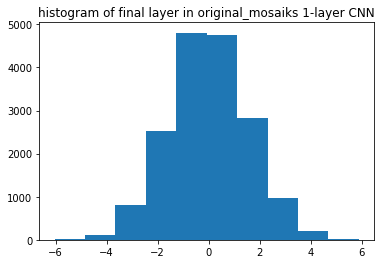

In [13]:
model_type = 'original_mosaiks'
for batch in geo_train_loader:
    patches, target, meta = batch
    patches['rgb'] = trf(patches['rgb'])
    final_output = forward(patches['rgb'])
    
#     relu_1_output = features_dim[f'relu_layer_1'].numpy()
#     plot_histogram(relu_1_output, f'histogram of l-relu#1 in {model_type} 2-layer CNN')    
    
#     relu_4_output = features_dim[f'relu_layer_4'].numpy()
#     plot_histogram(relu_4_output, f'histogram of l-relu#4 in {model_type} 2-layer CNN')  
    
    feats_np = final_output.data.numpy()
    plot_histogram(feats_np, f'histogram of final layer in {model_type} 1-layer CNN')
    
    break